# Oxford Pets - Multiclass Segmentation

## Modules

In [1]:
import os
import sys

common_dir = os.path.abspath("../../common")
print(os.listdir(common_dir))

if common_dir not in sys.path:
    sys.path.append(common_dir)

['pt_trainer.py', 'tf_trainer.py', 'utils.py', '__pycache__']


In [2]:
import torch
import torch.nn as nn
import torchvision

import random
import numpy as np
import matplotlib.pyplot as plt

from utils import show_images, plot_progress
from pt_trainer import TrainerWithMetrics, TrainerWithEarlyStopping
from pt_trainer import accuracy, binary_accuracy
from scipy.special import softmax, expit as sigmoid

## Parameters

In [3]:
use_cpu = False
use_cuda = not use_cpu and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

seed = 42
random.seed(seed)
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed_all(seed)

cuda


In [4]:
image_size = (224, 224)
batch_size = 30

In [5]:
save_weights = False
weights_name = "./pt_models/pt_oxford-pets_seg-3_unet.pth"

## Data Set

In [6]:
from glob import glob
import re
from sklearn.preprocessing import LabelEncoder
from collections import Counter

def get_paths(image_dir, formats=["*"]):
    invalid_images = ['Egyptian_Mau_14',  'Egyptian_Mau_139', 'Egyptian_Mau_145',
                      'Egyptian_Mau_156', 'Egyptian_Mau_167', 'Egyptian_Mau_177',
                      'Egyptian_Mau_186', 'Egyptian_Mau_191', 'Abyssinian_5',
                      'Abyssinian_34',    'chihuahua_121',    'beagle_116']
    paths = []
    for ext in formats:
        paths += glob(os.path.join(image_dir, f"*.{ext}"))

    valid_paths = []
    for path in paths:
        image_name = os.path.basename(path).split('.')[0]
        if image_name not in invalid_images:
            valid_paths.append(path)
    return valid_paths


def get_labels(image_paths, n_classes=37):
    image_names = [os.path.basename(path).split('.')[0] for path in image_paths]
    if n_classes == 2:
        labels = ['cat' if name[0].isupper() else 'dog' for name in image_names]
    else:
        labels = [re.sub('_\d+', '', name) for name in image_names]
    return labels

def get_class_names(labels):
    return list(Counter(labels).keys())

def label_encoder(labels, class_names):
    encoder = {name: i for i, name in enumerate(class_names)}
    return [encoder[label] for label in labels]

In [7]:
def change_paths(new_dir, old_paths, replace=("ext1", "ext2")):
    filenames = [os.path.basename(path).replace(replace[0], replace[1])
                 for path in old_paths]
    return [os.path.join(new_dir, name) for name in filenames]

In [8]:
data_dir = "/mnt/f/deep_learning/datasets/oxford_pets_783M/"
image_dir = os.path.join(data_dir, "images")
mask_dir = os.path.join(data_dir, "annotations", "trimaps")

image_paths = get_paths(image_dir, formats=['jpg'])
labels = get_labels(image_paths, n_classes=37)
class_names = get_class_names(labels)
labels = label_encoder(labels, class_names)

print(f">> Images: {len(image_paths)}")
print(">> Class Names:", class_names)

>> Images: 7378
>> Class Names: ['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer', 'British_Shorthair', 'chihuahua', 'Egyptian_Mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'Maine_Coon', 'miniature_pinscher', 'newfoundland', 'Persian', 'pomeranian', 'pug', 'Ragdoll', 'Russian_Blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'Siamese', 'Sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


In [9]:
from sklearn.model_selection import train_test_split

train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, stratify=labels, train_size=0.8, random_state=seed)

train_image_paths, valid_image_paths, train_labels, valid_labels = train_test_split(
    train_image_paths, train_labels, stratify=train_labels, train_size=0.75, random_state=seed)

train_mask_paths = change_paths(mask_dir, train_image_paths, replace=['jpg', 'png'])
valid_mask_paths = change_paths(mask_dir, valid_image_paths, replace=['jpg', 'png'])
test_mask_paths = change_paths(mask_dir, test_image_paths, replace=['jpg', 'png'])

n_images = len(image_paths)
print(f">> Train images: {len(train_image_paths)} ({len(train_image_paths)/n_images:.2f})")
print(f">> Valid images: {len(valid_image_paths)} ({len(valid_image_paths)/n_images:.2f})")
print(f">> Test  images: {len(test_image_paths)} ({len(test_image_paths)/n_images:.2f})")

>> Train images: 4426 (0.60)
>> Valid images: 1476 (0.20)
>> Test  images: 1476 (0.20)


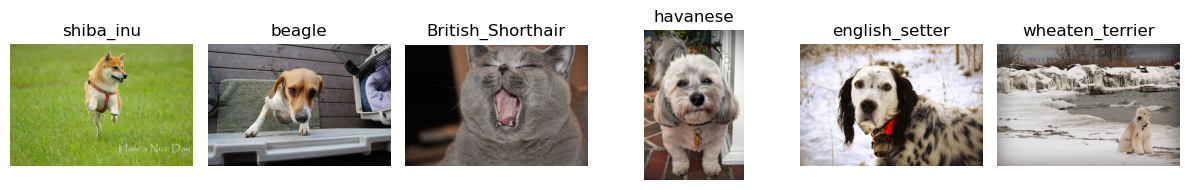

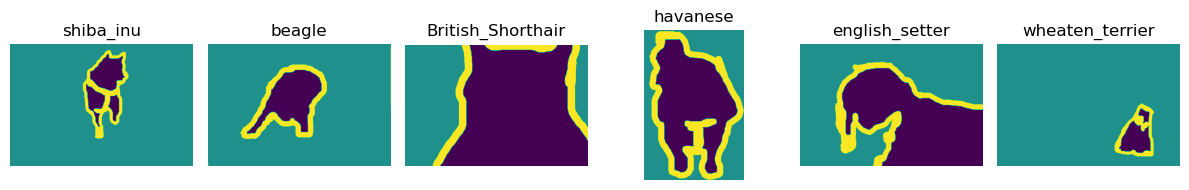

In [10]:
n_samples = 6
show_images(train_image_paths[:n_samples], labels=train_labels[:n_samples], 
            class_names=class_names, n_cols=6)
show_images(train_mask_paths[:n_samples], labels=train_labels[:n_samples], 
            class_names=class_names, n_cols=6)

## Data Loader

In [11]:
import cv2
import albumentations as A

class Dataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, mask_paths, training=False):
        super().__init__()
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = train_transform if training else valid_transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
       
        transformed = self.transform(image=image, mask=mask)
        image = transformed["image"]
        mask = transformed["mask"]
        
        # image = torch.tensor(image).permute(2, 0, 1).float()/255 # [0, 255] -> [0, 1]
        image = torch.tensor(image).permute(2, 0, 1).float() # [0, 255]
        mask -= 1
        mask = torch.tensor(mask).long()
        mask = nn.functional.one_hot(mask, num_classes=3).permute(2, 0, 1)
        return image, mask


train_transform = A.Compose([
    A.Resize(height=image_size[0], width=image_size[1]),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5, shift_limit=0.05, scale_limit=0.05, rotate_limit=15,),
    A.CoarseDropout(p=0.5, max_holes=8, max_height=int(0.1*image_size[0]), 
                    max_width=int(0.1*image_size[1])),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
valid_transform = A.Compose([
    A.Resize(height=image_size[0], width=image_size[1]),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])

train_loader = torch.utils.data.DataLoader(
        Dataset(train_image_paths, train_mask_paths, training=True), 
        batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=False)
valid_loader = torch.utils.data.DataLoader(
        Dataset(valid_image_paths, valid_mask_paths, training=False), 
        batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=False)
test_loader = torch.utils.data.DataLoader(
        Dataset(test_image_paths, test_mask_paths, training=False), 
        batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=False)

<class 'torch.Tensor'> torch.Size([30, 3, 224, 224]) torch.float32
<class 'torch.Tensor'> torch.Size([30, 3, 224, 224]) torch.int64
>> Images: min: -2.1179039478302, max: 2.6399998664855957
>> Masks:  min: 0.0, max: 1.0


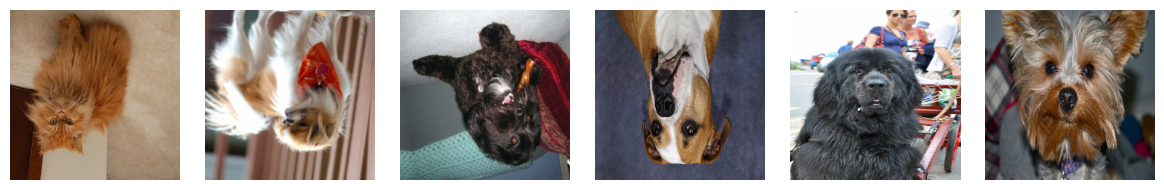

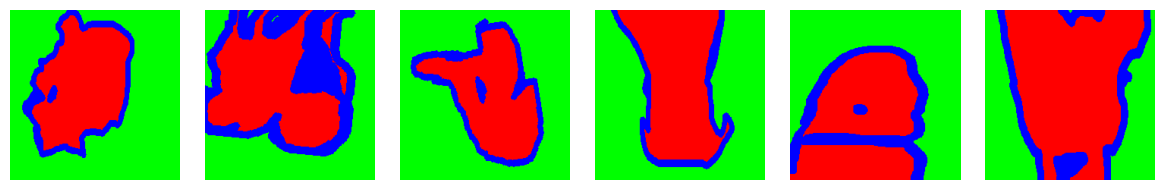

In [12]:
images, masks = next(iter(train_loader))
print(type(images), images.shape, images.dtype)
print(type(masks), masks.shape, masks.dtype)

images = images.permute(0, 2, 3, 1).numpy()
masks = masks.permute(0, 2, 3, 1).numpy().astype(float)

n_samples = 6
print(f">> Images: min: {images.min()}, max: {images.max()}")
print(f">> Masks:  min: {masks.min()}, max: {masks.max()}")

show_images(images[:n_samples], n_cols=n_samples, denormalize=True)
show_images(masks[:n_samples], n_cols=n_samples)

### Modeling

In [13]:
# print(torch.__version__)
# print(torchvision.__version__)
# dir(torchvision.models)

In [14]:
# !pip install segmentation-models-pytorch

In [15]:
import segmentation_models_pytorch as smp

# unet = smp.Unet(encoder_name='mobilenet_v2', encoder_weights='imagenet',
#                 in_channels=3, classes=3).to(device)

# class PretrainedUnet(nn.Module):
#     def __init__(self, model_name, in_channels, n_classes):
#         super().__init__()
#         self.model = smp.Unet(encoder_name=model_name, 
#                  encoder_weights='imagenet', 
#                  in_channels=in_channels, classes=n_classes)
#         self.preprocess_input = smp.encoders.get_preprocessing_fn(
#             model_name, pretrained='imagenet')
    
#     def forward(self, inputs):
#         x = inputs.permute(0, 2, 3, 1).cpu()
#         x = self.preprocess_input(x).permute(0, 3, 1, 2).to(device)
#         outputs = self.model(x)
#         return outputs

In [16]:
# x, y = next(iter(train_loader))

# preprocess_input = smp.encoders.get_preprocessing_fn(
#             'timm-mobilenetv3_large_100', pretrained='imagenet')

# preprocess_input(x[0].permute(1, 2, 0))

In [17]:
from pt_trainer import iou, dice_coeff, MulticlassIOU, MulticlassDiceCoeff

def ce_dice_loss(y_pred, y_true):
    ce_loss = nn.CrossEntropyLoss()(y_pred, y_true)
    dice_coeff = MulticlassDiceCoeff(n_classes=4)
    dice_loss = 1 - dice_coeff(y_pred, y_true)
    return ce_loss + dice_loss

In [18]:
def iou_score(y_pred, y_true, n_classes=3):
    # y_true = nn.functional.one_hot(y_true, n_classes).permute(0, 3, 1, 2)
    tp, fp, fn, tn = smp.metrics.get_stats(y_pred, y_true, mode='multilabel', threshold=0.5)
    return smp.metrics.iou_score(tp, fp, fn, tn, reduction='micro')

def f1_score(y_pred, y_true, n_classes=3):
    # y_true = nn.functional.one_hot(y_true, n_classes).permute(0, 3, 1, 2)
    tp, fp, fn, tn = smp.metrics.get_stats(y_pred, y_true, mode='multilabel', threshold=0.5)
    return smp.metrics.f1_score(tp, fp, fn, tn, reduction='micro')

def bal_accuracy(y_pred, y_true, n_classes=3):
    # y_true = nn.functional.one_hot(y_true, n_classes).permute(0, 3, 1, 2)
    tp, fp, fn, tn = smp.metrics.get_stats(y_pred, y_true, mode='multilabel', threshold=0.5)
    return smp.metrics.balanced_accuracy(tp, fp, fn, tn, reduction='micro')

## Training

In [22]:
%%time
model = smp.Unet('timm-mobilenetv3_large_100', in_channels=3, classes=3).to(device)
optimizer = torch.optim.Adam(model.parameters())
# loss_fn = smp.losses.DiceLoss(mode='multiclass')
loss_fn = smp.losses.FocalLoss(mode='multilabel')
metrics={'iou': iou_score, 'f1': f1_score, 'acc': bal_accuracy}

clf = TrainerWithEarlyStopping(model, optimizer, loss_fn, metrics)
hist = clf.fit(train_loader, n_epochs=10, valid_loader=valid_loader)

results = clf.evaluate(test_loader)
print(">>", ', '.join([f"test_{key}={value:.4f}" for key, value in results.items()]))

Epoch[  1/ 10] loss=0.0668, iou=0.6472, f1=0.7639, acc=0.8234 | val_loss=0.0402, val_iou=0.7576, val_f1=0.8620, val_acc=0.8813 (1)
Epoch[  2/ 10] loss=0.0412, iou=0.7622, f1=0.8649, acc=0.8842 | val_loss=0.0383, val_iou=0.7858, val_f1=0.8800, val_acc=0.8962 (1)
Epoch[  3/ 10] loss=0.0376, iou=0.7871, f1=0.8808, acc=0.8970 | val_loss=0.0373, val_iou=0.7937, val_f1=0.8849, val_acc=0.9005 (1)
Epoch[  4/ 10] loss=0.0344, iou=0.8062, f1=0.8926, acc=0.9068 | val_loss=0.0366, val_iou=0.8056, val_f1=0.8922, val_acc=0.9070 (1)
Epoch[  5/ 10] loss=0.0329, iou=0.8120, f1=0.8961, acc=0.9096 | val_loss=0.0336, val_iou=0.8232, val_f1=0.9030, val_acc=0.9156 (1)
Epoch[  6/ 10] loss=0.0317, iou=0.8183, f1=0.9000, acc=0.9127 | val_loss=0.0392, val_iou=0.7899, val_f1=0.8825, val_acc=0.8991 (2)
Epoch[  7/ 10] loss=0.0312, iou=0.8197, f1=0.9009, acc=0.9134 | val_loss=0.0328, val_iou=0.8240, val_f1=0.9034, val_acc=0.9157 (1)
Epoch[  8/ 10] loss=0.0293, iou=0.8282, f1=0.9060, acc=0.9175 | val_loss=0.0325, va

In [23]:
# if save_weights:
#     torch.save(model, weights_name)

## Inference

In [24]:
# if save_weights:
#     model = CustomUnet(in_channels=3, out_channels=3).to(device)
#     model.load_state_dict(torch.load(weights_name))

>> Ground Truth:


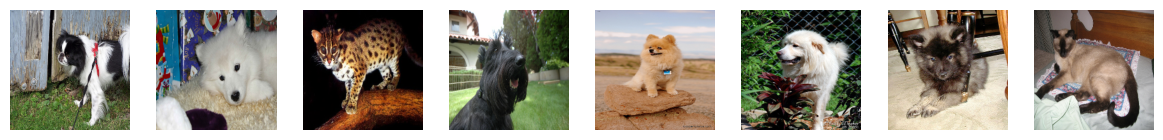

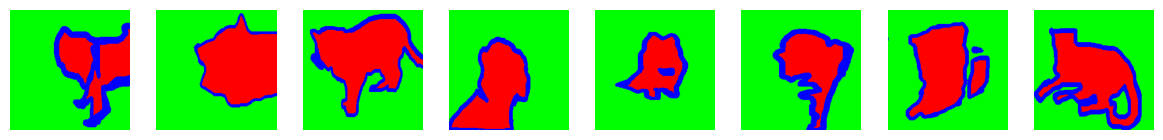

>> Predictions:


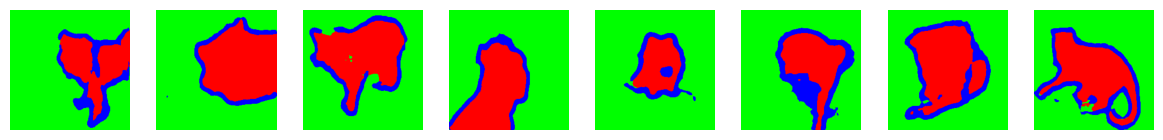

In [27]:
images, masks = next(iter(test_loader))

model.eval()
preds = model(images.to(device)).detach().cpu()

images = images.permute(0, 2, 3, 1).numpy()
masks = masks.permute(0, 2, 3, 1).numpy().astype(float)
# preds = preds.permute(0, 2, 3, 1).numpy()
preds = nn.functional.one_hot(preds.argmax(dim=1), 3).numpy().astype(float)

n_samples = 8
print(">> Ground Truth:")
show_images(images[:n_samples], n_cols=n_samples, denormalize=True)
show_images(masks[:n_samples], n_cols=n_samples)

print(">> Predictions:")
show_images(preds[:n_samples], n_cols=n_samples)

In [26]:
preds.min(), preds.max()

(0.0, 1.0)